In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch import optim
#keep

# Basic image classification

In this notebook, we are going to train a basic CNN on the MNIST dataset, a small dataset that contains handwritten digits.

## Implementing a Simple CNN

You can use [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to create a single convolutional layer in PyTorch. Some of its interesting arguments are:

- `in_channels`: the number of channels in the input tensor. When the input is an RGB image, this is `3`. For a single-channel gray scale image, this is `1`. Note that each convolution filter in the layer will have this amount of channels as the filter needs to cover the *entire depth* of the input.
- `out_channels`: the number of convolution filters that this layer has. Each filter will produce a new channel in the output. As such, if another `nn.Conv2d()` takes the output of this layer as its input, that layer's `in_channels` should be set to this layer's `out_channels`.
- `kernel_size`: the height and width of the convolution filters. If this is a single integer, it will be used for both the height and the width (i.e., square filters).
- `stride`: the stride (step size) of the convolution operation (default: `1`).
- `padding`: the amount of padding to add to the input (default: `0`). *Padding* is a border of black pixels that is added around the input image. This allows more of the convolution operation to be applied to the pixels at the edge of the image and can avoid the output resolution to shrink w.r.t. the input resolution. When `padding` is set to `1`, a black border of a single pixel wide will be added at each image edge.

Apart from convolutional layers, a CNN also typically contains *pooling layers*. Similar to conv layers, a pooling layer uses a sliding window to operate on its input. Instead of computing an inner product, however, the pooling window **aggregates** the underlying values, e.g., by computing the *maximum* or *average* value. For example:

- [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) applies max pooling.
- [`nn.AvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) applies average pooling.

Just like `nn.Conv2d()`, these pooling layers take `kernel_size`, `stride` (default: `1`) and `padding` (default: `0`) as an argument.

The pooling layers also have *adaptive* equivalents: [`nn.AdaptiveMaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html) and [`nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html). These adaptive layers produce an **output of a fixed, predefined width and height no matter the input size** (the number of channels stays the same). This is in contrast with regular pooling layers, where the output size depends on the input size.

There are multiple ways to tie layers together into a network. One of the easiest ways is through [`nn.Sequential()`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). You can check out the corresponding documentation for more info and examples.

Create a neural network with the following layers:

- A `Conv2d` layer with 64 5x5 filters, stride 2 and padding 2
- An `AdaptiveAvgPool2d` layer that outputs width and height 1
- A `Flatten` layer that flattens it input to shape `(N,64)`
- A `Linear` (i.e., fully-connected) layer that transforms its input to 10 output values, corresponding to the 10 classes in the MNIST dataset.

In [46]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 64, 5, stride=2, padding=2),
    torch.nn.AdaptiveAvgPool2d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(64, 10)
)



Let's try and train our model! But first, we'll need two more things:

1. Data to train on
2. Training logic

We'll define both in the following two sections.

## Obtaining the Data for Batch Training

In the cell below, we have defined a function that returns all images and the corresponding labels for a subset of the MNIST dataset (i.e., the training set when `train=True`, the validation set when `train=False`).

In [47]:
from torchvision.datasets import MNIST

def get_mnist(train=True):
    mnist = MNIST(root='../data', download=True, train=train)
    data = ((mnist.data.float()[:, None, :, :] / 255))
    half_len = len(data) // 2

    return data[:half_len], mnist.targets[:half_len]

#keep

Use this function to create the training and validation set. Inspect the shapes of the returned tensors.

In [48]:
x_train, y_train = get_mnist(train=True)
x_val, y_val = get_mnist(train=False)
print(f"x_train.shape = {x_train.shape}\ty_train.shape = {y_train.shape}\nx_val.shape = {x_val.shape}\ty_val.shape = {y_val.shape}")

x_train.shape = torch.Size([30000, 1, 28, 28])	y_train.shape = torch.Size([30000])
x_val.shape = torch.Size([5000, 1, 28, 28])	y_val.shape = torch.Size([5000])


## Defining the Training Loop

Now that we have our first model and data ready, we can define our training loop! We have already implemented it below. Read through it, and **ensure that you understand what's happening**. The function **returns three lists**: the first one contains the training losses, the second one the validation losses and the third one the validation accuracies throughout training.

In [49]:
def train_classifier(model, x_train, y_train, x_val, y_val, optimizer, loss_fn, num_epochs):
    """# ... WRITE YOUR CODE HERE ... #
    Train a classifier using batch gradient descent.

    Args:
        model: The classification model.
        x_train: A Tensor containing the training images.
        y_train: A Tensor with the true label of each training image.
        x_val: A Tensor containing the validation images.
        y_val: A Tensor with the true label of each validation image.
        optimizer: The optimizer.
        loss_fn: The loss function.
        num_epochs: The number of epochs to train.
    """
    train_loss_curve = []
    val_loss_curve = []
    val_acc_curve = []

    # Iterate over the epochs
    for epoch in range(num_epochs):
        # Put model in training mode
        model.train()

        # Compute predictions
        y_pred = model(x_train)

        # Compute loss
        loss = loss_fn(y_pred, y_train)

        # Backpropagate + optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append to train loss curve
        train_loss_curve.append(loss.detach().cpu().numpy())

        # Put model in evaluation mode
        model.eval()

        # Compute predictions (without storing gradients)
        with torch.inference_mode():
            y_pred = model(x_val)

        # Compute validation loss
        loss = loss_fn(y_pred, y_val)
        val_loss_curve.append(loss.cpu().numpy())

        # Compute validation accuracy
        acc = (y_val == y_pred.argmax(dim=1)).float().mean()
        val_acc_curve.append(acc.cpu().numpy())

        if epoch % 10 == 0:
            # Log losses
            print(f"Train loss at epoch {epoch}: {train_loss_curve[-1]:.4f}")
            print(f"Validation loss after epoch {epoch}: {val_loss_curve[-1]:.4f}")
            print(f"Validation accuracy after epoch {epoch}: {val_acc_curve[-1]:.4f}")
            print()

    return np.array(train_loss_curve), np.array(val_loss_curve), np.array(val_acc_curve)
#keep

## Running the Training

Time to train our home-grown CNN! 🪴

- Define a loss function for training classification (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions)). Use cross entropy loss.
- Create an optimizer (see [here](https://pytorch.org/docs/stable/optim.html)). Use the Adam algorithm.
- Call `train_classifier()`, and store the returned training and validation curves. Train for 100 epochs.

In [50]:
train_classifier(model=model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, optimizer=torch.optim.Adam(model.parameters()), loss_fn=torch.nn.CrossEntropyLoss(), num_epochs=100)

Train loss at epoch 0: 2.3041
Validation loss after epoch 0: 2.3018
Validation accuracy after epoch 0: 0.0998

Train loss at epoch 10: 2.2905
Validation loss after epoch 10: 2.2915
Validation accuracy after epoch 10: 0.1188

Train loss at epoch 20: 2.2788
Validation loss after epoch 20: 2.2815
Validation accuracy after epoch 20: 0.1054

Train loss at epoch 30: 2.2663
Validation loss after epoch 30: 2.2700
Validation accuracy after epoch 30: 0.1196

Train loss at epoch 40: 2.2526
Validation loss after epoch 40: 2.2569
Validation accuracy after epoch 40: 0.1334

Train loss at epoch 50: 2.2380
Validation loss after epoch 50: 2.2429
Validation accuracy after epoch 50: 0.1606

Train loss at epoch 60: 2.2230
Validation loss after epoch 60: 2.2286
Validation accuracy after epoch 60: 0.1944

Train loss at epoch 70: 2.2080
Validation loss after epoch 70: 2.2142
Validation accuracy after epoch 70: 0.2196

Train loss at epoch 80: 2.1932
Validation loss after epoch 80: 2.1998
Validation accuracy a

(array([2.3040757, 2.3024306, 2.3008747, 2.2993991, 2.297994 , 2.2966497,
        2.2953556, 2.2941015, 2.2928782, 2.291679 , 2.290497 , 2.2893276,
        2.2881665, 2.2870097, 2.285855 , 2.2846997, 2.2835414, 2.2823782,
        2.2812083, 2.280031 , 2.2788434, 2.2776456, 2.2764359, 2.275214 ,
        2.2739794, 2.2727313, 2.27147  , 2.2701955, 2.268908 , 2.267608 ,
        2.266296 , 2.2649722, 2.263637 , 2.2622905, 2.2609332, 2.259565 ,
        2.2581868, 2.256798 , 2.2553997, 2.2539914, 2.252574 , 2.251148 ,
        2.2497137, 2.2482717, 2.246822 , 2.245366 , 2.2439036, 2.2424352,
        2.2409618, 2.239483 , 2.238    , 2.2365136, 2.2350225, 2.233529 ,
        2.2320333, 2.2305348, 2.229035 , 2.227533 , 2.22603  , 2.2245264,
        2.2230215, 2.2215164, 2.2200115, 2.2185073, 2.2170033, 2.2155006,
        2.2139986, 2.2124982, 2.2109993, 2.2095025, 2.2080073, 2.2065146,
        2.205024 , 2.2035367, 2.2020519, 2.20057  , 2.1990914, 2.1976159,
        2.196144 , 2.1946757, 2.193211

You might notice that the training progresses rather slowly. Feel free to cancel it. **Move all data, as well as the model to the GPU** by calling [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html), with `device` set to `'cuda'` if CUDA is available, else `'cpu'`.

In [62]:
device = 'cuda'
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

model = model.to(device)

train_loss_curve, val_loss_curve, val_acc_curve =  train_classifier(model=model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, optimizer=torch.optim.Adam(model.parameters()), loss_fn=torch.nn.CrossEntropyLoss(), num_epochs=100)

Train loss at epoch 0: 2.0798
Validation loss after epoch 0: 2.0862
Validation accuracy after epoch 0: 0.2054

Train loss at epoch 10: 2.0748
Validation loss after epoch 10: 2.0820
Validation accuracy after epoch 10: 0.2060

Train loss at epoch 20: 2.0708
Validation loss after epoch 20: 2.0785
Validation accuracy after epoch 20: 0.2054

Train loss at epoch 30: 2.0679
Validation loss after epoch 30: 2.0763
Validation accuracy after epoch 30: 0.2058

Train loss at epoch 40: 2.0660
Validation loss after epoch 40: 2.0751
Validation accuracy after epoch 40: 0.2074

Train loss at epoch 50: 2.0647
Validation loss after epoch 50: 2.0745
Validation accuracy after epoch 50: 0.2074

Train loss at epoch 60: 2.0640
Validation loss after epoch 60: 2.0742
Validation accuracy after epoch 60: 0.2078

Train loss at epoch 70: 2.0634
Validation loss after epoch 70: 2.0740
Validation accuracy after epoch 70: 0.2078

Train loss at epoch 80: 2.0630
Validation loss after epoch 80: 2.0738
Validation accuracy a

Redefine the optimizer (since our old optimizer still holds the cpu parameters) and call `train_classifier` again. **Do you notice a speed-up?**

In [63]:
# ... WRITE YOUR CODE HERE ... #

Plot the train loss curve, validation loss curve and the validation accuracy curve using Matplotlib.

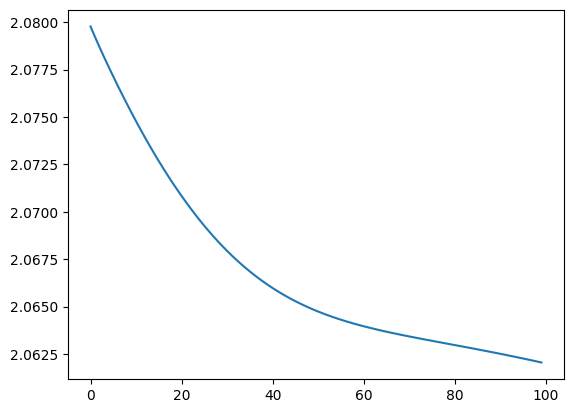

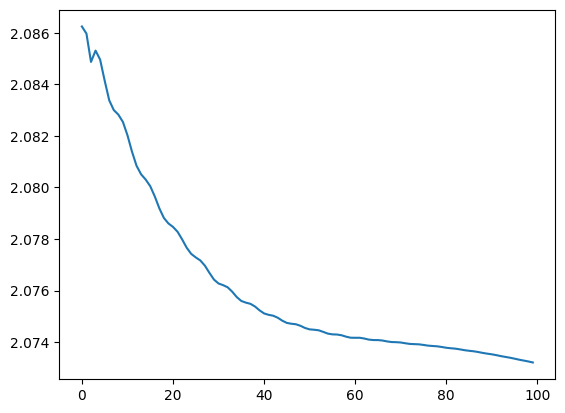

[]

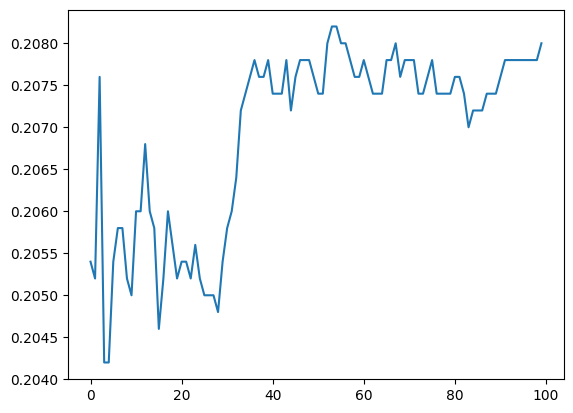

In [64]:
plt.plot(train_loss_curve)
plt.show()

plt.plot(val_loss_curve)
plt.show()

plt.plot(val_acc_curve)
plt.plot()


## Improve the model

Create a new model based on the previous one, but add an extra convolutional layer after the first one with the same hyper parameters. Make sure the number of input channels of the new layer matches the number of output channels of its predecessor.

In [65]:
model2 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 64, 5, stride=2, padding=2),
    torch.nn.Conv2d(64, 64, 5, stride=2, padding=2),
    torch.nn.AdaptiveAvgPool2d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(64, 10)
)

device = 'cuda'
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

model2 = model2.to(device)

train_loss_curve, val_loss_curve, val_acc_curve =  train_classifier(model=model2, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, optimizer=torch.optim.Adam(model2.parameters()), loss_fn=torch.nn.CrossEntropyLoss(), num_epochs=100)

Train loss at epoch 0: 2.3043
Validation loss after epoch 0: 2.2921
Validation accuracy after epoch 0: 0.0994

Train loss at epoch 10: 2.1199
Validation loss after epoch 10: 2.1286
Validation accuracy after epoch 10: 0.2282

Train loss at epoch 20: 2.0253
Validation loss after epoch 20: 2.0371
Validation accuracy after epoch 20: 0.2586

Train loss at epoch 30: 1.9771
Validation loss after epoch 30: 1.9815
Validation accuracy after epoch 30: 0.2758

Train loss at epoch 40: 1.9320
Validation loss after epoch 40: 1.9413
Validation accuracy after epoch 40: 0.2964

Train loss at epoch 50: 1.8925
Validation loss after epoch 50: 1.9082
Validation accuracy after epoch 50: 0.3178

Train loss at epoch 60: 1.8441
Validation loss after epoch 60: 1.8641
Validation accuracy after epoch 60: 0.3370

Train loss at epoch 70: 1.7803
Validation loss after epoch 70: 1.8039
Validation accuracy after epoch 70: 0.3622

Train loss at epoch 80: 1.7108
Validation loss after epoch 80: 1.7400
Validation accuracy a

Move the new model to GPU, redefine the optimizer and train it. Plot the train loss curve, validation loss curve and the validation accuracy curve using Matplotlib.

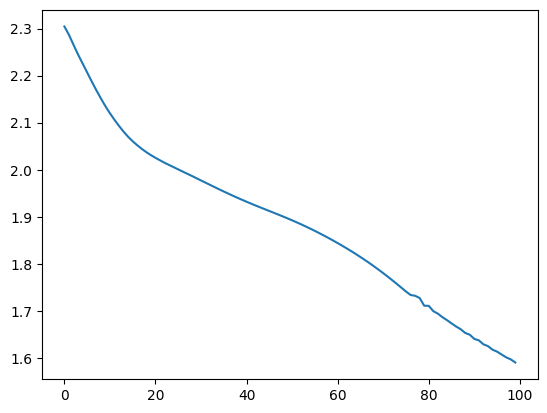

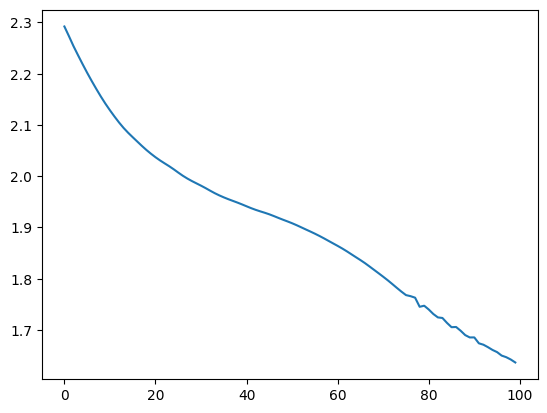

[]

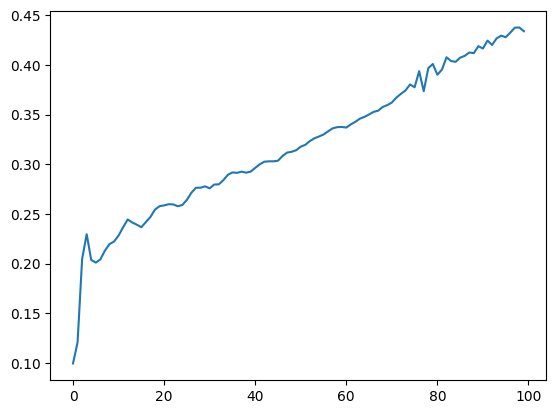

In [66]:
plt.plot(train_loss_curve)
plt.show()

plt.plot(val_loss_curve)
plt.show()

plt.plot(val_acc_curve)
plt.plot()

Compare the loss curves of the new model with the first one.
Create a new model  based on the previous one, but wow **insert a `ReLU` layer after each convolution**.

In [70]:
model3 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 64, 5, stride=2, padding=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, 5, stride=2, padding=2),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(64, 10)
)

device = 'cuda'
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

model3 = model3.to(device)

train_loss_curve, val_loss_curve, val_acc_curve =  train_classifier(model=model3, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, optimizer=torch.optim.Adam(model3.parameters(), lr=0.01), loss_fn=torch.nn.CrossEntropyLoss(), num_epochs=100)

Train loss at epoch 0: 2.3030
Validation loss after epoch 0: 2.6096
Validation accuracy after epoch 0: 0.0920

Train loss at epoch 10: 2.2175
Validation loss after epoch 10: 2.1851
Validation accuracy after epoch 10: 0.2176

Train loss at epoch 20: 1.8703
Validation loss after epoch 20: 1.8519
Validation accuracy after epoch 20: 0.3170

Train loss at epoch 30: 1.5846
Validation loss after epoch 30: 1.5910
Validation accuracy after epoch 30: 0.4510

Train loss at epoch 40: 1.3009
Validation loss after epoch 40: 1.3363
Validation accuracy after epoch 40: 0.5556

Train loss at epoch 50: 1.0205
Validation loss after epoch 50: 1.0603
Validation accuracy after epoch 50: 0.6600

Train loss at epoch 60: 0.7668
Validation loss after epoch 60: 0.8165
Validation accuracy after epoch 60: 0.7516

Train loss at epoch 70: 0.6110
Validation loss after epoch 70: 0.6715
Validation accuracy after epoch 70: 0.8080

Train loss at epoch 80: 0.4916
Validation loss after epoch 80: 0.5468
Validation accuracy a

Move the new model to GPU, redefine the optimizer and train it. Plot the train loss curve, validation loss curve and the validation accuracy curve using Matplotlib.

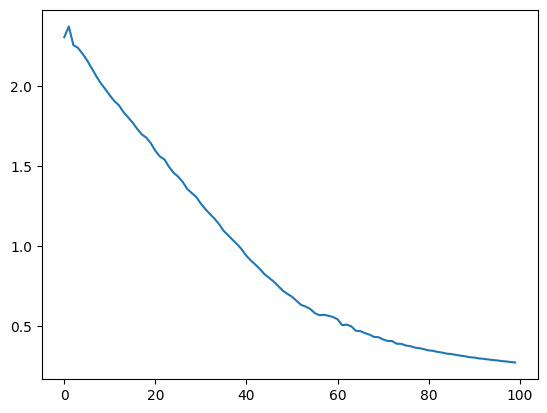

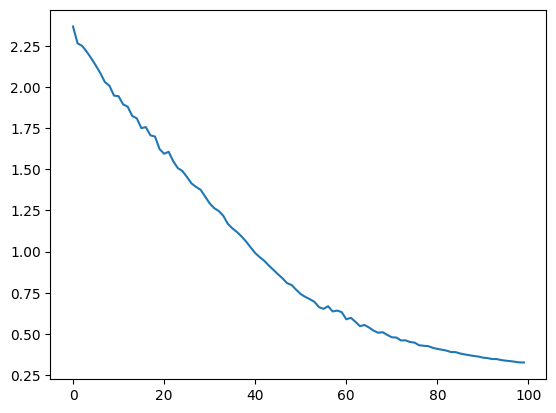

Fri Oct 25 16:41:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        Off |   00000000:01:00.0  On |                  N/A |
| 32%   38C    P8             N/A /  115W |    7291MiB /   8188MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

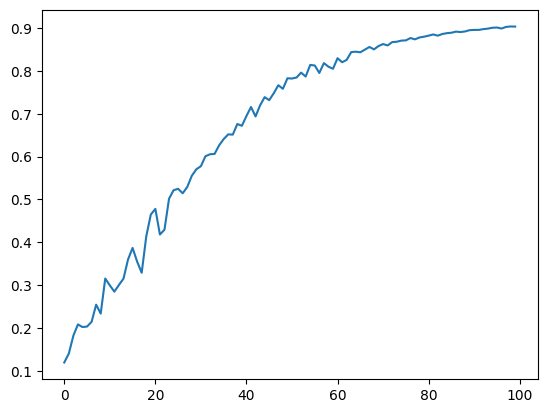

In [69]:
plt.plot(train_loss_curve)
plt.show()

plt.plot(val_loss_curve)
plt.show()

plt.plot(val_acc_curve)
plt.plot()

Again compare the loss curves of this model with the previous two. What do you notice?

## Inspecting the results

Pass all validation samples through your best model and store the results in a variable `y_pred`. Hint: look at the validation routine inside `train_classifier`

In [78]:
# ... WRITE YOUR CODE HERE ... #
with torch.inference_mode():
    y_pred = model3(x_val).argmax(dim=1)
y_pred.shape

torch.Size([5000])

Now write code to **select a random sample from the validation set**. **Visualize the sample** using Matplotlib and put the **predicted label and true label in the title** of the figure. Hint: use the index of the neuron with the largest output value as prediction.

tensor(1, device='cuda:0')


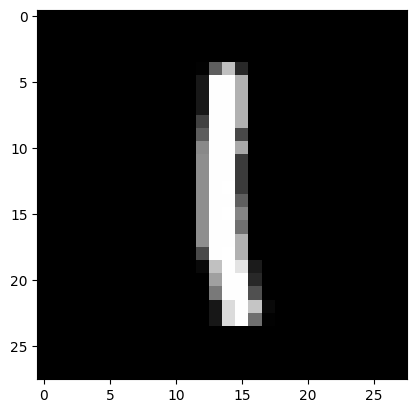

In [97]:
import random
sample_index = random.randint(0, 4999)
x = x_val[sample_index]
y = y_pred[sample_index]

plt.imshow(x_val[sample_index][0].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
print(y)

Use [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and [`sklearn.metrics.ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) to visualize the confusion matrix.

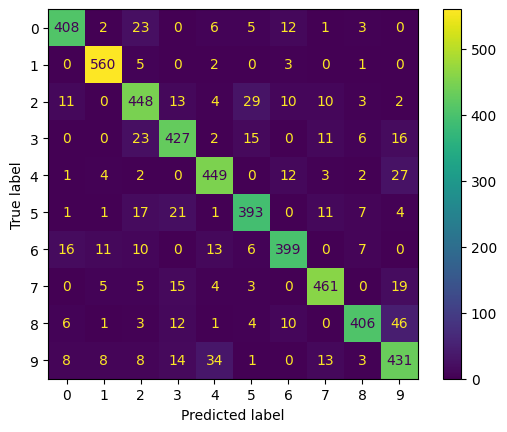

In [100]:
# ... WRITE YOUR CODE HERE ... #
import sklearn
cm = sklearn.metrics.confusion_matrix(y_val.cpu().numpy(), y_pred.cpu().numpy())
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()